In [1]:
%matplotlib inline
from pprint import pprint

import plot
from simulate import simulate_withdrawals
import harvesting
import market
import withdrawal
import metrics

from decimal import Decimal

import itertools
import math
import pandas

In [2]:
YEARS = 25

In [3]:
def run_comparison(series):
    (r1, r2) = itertools.tee(series)
    p1 = (1214000 * .6, 1214000 * .4)
    p2 = (2459000, 0)
    
    sim1 = simulate_withdrawals(r1, years=YEARS, harvesting=harvesting.N_60_RebalanceHarvesting, withdraw=withdrawal.VPW, portfolio=p1)
    sim2 = simulate_withdrawals(r2, years=YEARS, harvesting=harvesting.N_100_RebalanceHarvesting, withdraw=withdrawal.VPW, portfolio=p2)

    s1 = [n.withdraw_r for n in sim1]
    s2 = [n.withdraw_r for n in sim2]
    
    return (s1, s2)

/Users/justus/Dropbox/jupyter/prime-harvesting/market.py:149: ParserWarning: Both a converter and dtype were specified for column Spliced Bond - only the converter will be used
  'NIKKEI225' : Decimal})
/Users/justus/Dropbox/jupyter/prime-harvesting/market.py:149: ParserWarning: Both a converter and dtype were specified for column NIKKEI225 - only the converter will be used
  'NIKKEI225' : Decimal})
/Users/justus/Dropbox/jupyter/prime-harvesting/market.py:149: ParserWarning: Both a converter and dtype were specified for column CPI Japan - only the converter will be used
  'NIKKEI225' : Decimal})
/Users/justus/anaconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to e

60/40 27342
100/0 19477


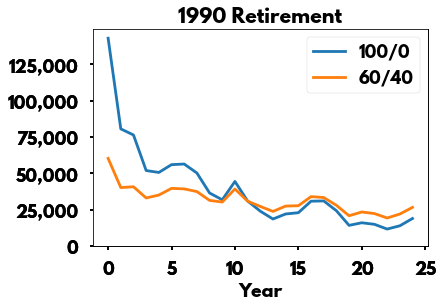

In [4]:
#MARKET = market.Returns_US_1871()
#MARKET = market.PortfolioCharts_1927(market.PortfolioCharts_1927.Weights(LCB=.8, SCV=.2))
MARKET = market.Japan_1957()

RETIRE_YEAR = 1990
s1, s2, = run_comparison(MARKET.iter_from(RETIRE_YEAR))
print("60/40", int(metrics.cew(s1)))
print("100/0", int(metrics.cew(s2)))
plot.plot_n({'60/40' : s1, '100/0': s2}, 'Year', '%d Retirement' % RETIRE_YEAR)

In [5]:
incomes_60 = []
incomes_100 = []

for i in range(MARKET.start_year, 2016-YEARS):
    s1, s2 = run_comparison(MARKET.iter_from(i))
    incomes_60 += [int(n) for n in s1]
    incomes_100 += [int(n) for n in s2]
    
incomes_60 = pandas.Series(data=incomes_60)
incomes_100 = pandas.Series(data=incomes_100)
diff = incomes_100 - incomes_60
print('60', incomes_60.quantile(.01))
print('100', incomes_100.quantile(.01))

df = pandas.DataFrame(data={'60/40' : incomes_60, '100/0' : incomes_100, 'Delta' : diff})

60 24457.92
100 17925.43


In [6]:
def index_to_year(n):
    year_of_retirement = n//YEARS + 1871
    year_of_income = n%YEARS + year_of_retirement
    return "%d/%d" % (year_of_retirement, year_of_income)

df['Income date'] = df.index.map(index_to_year)
df.head()

,100/0,60/40,Delta,Income date
0,143024,60347,82677,1871/1871
1,129806,57209,72597,1871/1872
2,182562,74405,108157,1871/1873
3,225751,83145,142606,1871/1874
4,329370,106343,223027,1871/1875


In [7]:
low_income = df.loc[(df['60/40'] < 40000) | (df['100/0'] < 40000)]

win_100 = low_income.sort_values('Delta', ascending=False)
win_60 = low_income.sort_values('Delta', ascending=True)

print(win_60.head())

     100/0  60/40  Delta Income date
848  13965  22036  -8071   1904/1927
824  16340  24258  -7918   1903/1927
799  18337  26004  -7667   1902/1926
849  18985  26636  -7651   1904/1928
847  11722  19337  -7615   1904/1926
